# Guardian AI

In [130]:
# Импорт необходимых библиотек
from inference_sdk import InferenceHTTPClient
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import supervision as sv
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

---
## Настройка клиента Roboflow
---

In [131]:
# Инициализация клиента Roboflow для работы с API
client = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",
    api_key="hYL2Xwn5YwGqerfLvDkm"  # Ваш API-ключ
)

---
## Подготовка базы данных   
#### (время последней фиксации редкого вида)
---

In [132]:
last_seen_db = {
    "amur tiger":   datetime(2025, 12, 15),
    "snow leopard": datetime(2025, 12, 10),
    "red wolf":     datetime(2025, 12, 10),
    "amur leopard": datetime(2025, 12, 15)
}

---
## Загрузка и преобразование изображения
---

In [ ]:
# URL тестового изображения для анализа (Подразумевается URL из облака, куда сохраняются фото с фотоловушек)
image_url = "https://zooofoto.ru/foto/3471/fotki_krasnogo_volka_2.webp" 

# Загрузка изображения 
response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).convert("RGB")
image_np = np.array(image) # Преобразование в numpy-массив для распознавания

---
## Распознавание фото
---

In [134]:
# Выполнение распознавания c помощью готовой модели через workflow Roboflow 
result = client.run_workflow(
    workspace_name="hks-s-workspace",
    workflow_id="find-amur-leopards-amur-tigers-red-wolves-and-snow-leopards",
    images={"image": image_np},
    use_cache=True
)

---
## Обработка результата
---

In [135]:
# Результат от API приходит в виде списка словарей, одна картинка - один словарь.
prediction_data = result[0] 

# Преобразуем в формат Supervision для удобства
detections = sv.Detections.from_inference(prediction_data["predictions"])
           
# Обновляем базу наблюдений для найденных видов,
if len(detections) > 0:
    for animal_class in detections.data["class_name"]:
        last_seen_db[animal_class] = datetime.now()
        print(f'Обнаружен {animal_class} в {datetime.now().strftime("%d-%m-%Y")}.\nID Фотоловушки: 42')
        
        

        

Обнаружен red wolf в 25-12-2025.
ID Фотоловушки: 42


---
## Визуализация распознавания
---

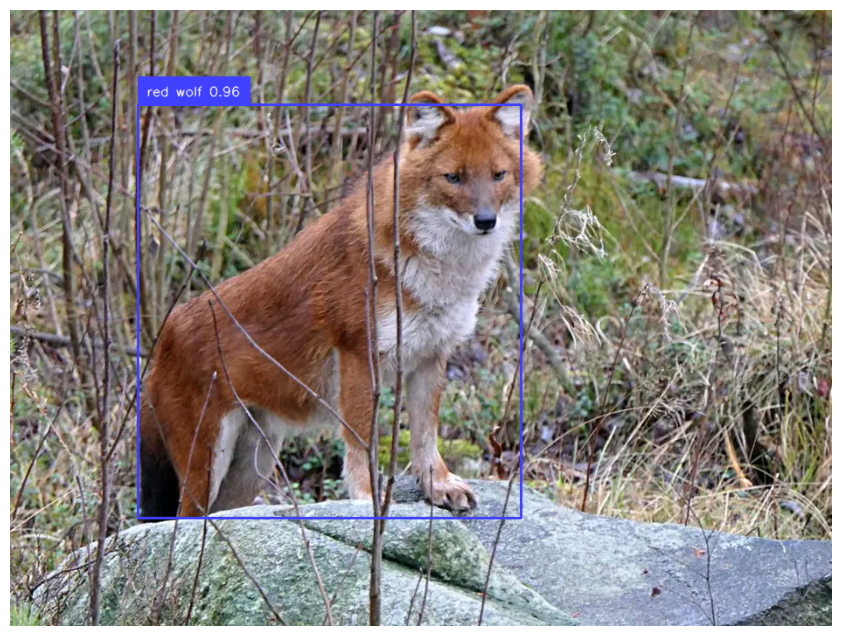

In [136]:
# Создание визуализации поверх фото, рамка и подпись обнаруженного вида.
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
   

# Рамка поверх снимка     
annotated_image = box_annotator.annotate(
    scene=image_np.copy(),
    detections=detections
)
 
# подпись обнаруженного вида с выводом доверительной вероятности   
for class_name, confidence in zip(detections.data["class_name"], detections.confidence):    
    labels = [f"{class_name} {confidence:.2f}"]
    
annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections,
    labels=labels
)
        
# Отображение снимка и доп. визуализаций
plt.figure(figsize=(12, 8))
plt.imshow(annotated_image)
plt.axis('off')
plt.show()

---
## Проверка пропажи активности
---

In [138]:
# Проверяем всех животных в базе на предмет пропажи активности
for animal, last_seen in last_seen_db.items():
    if datetime.now() - last_seen > timedelta(days=14):
        print(f"ВНИМАНИЕ! {animal} последний раз был замечен {last_seen.strftime('%d-%m-%Y')})")

ВНИМАНИЕ! snow leopard последний раз был замечен 10-12-2025)
